# SpikingJelly 神经元模型全面对比

对比所有可用神经元，分析各自的输入/输出类型、状态变量、动力学行为，评估哪个最适合隐神经元状态空间设计。

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from spikingjelly.activation_based import neuron, surrogate
from spikingjelly import visualizing

# 配置中文字体
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'Droid Sans Fallback', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

torch.manual_seed(42)
print('环境加载成功')
print(f'中文字体: {matplotlib.rcParams["font.sans-serif"][:2]}')

环境加载成功
中文字体: ['Noto Sans CJK JP', 'Droid Sans Fallback']


## 1. 统一实验：同一输入，所有神经元

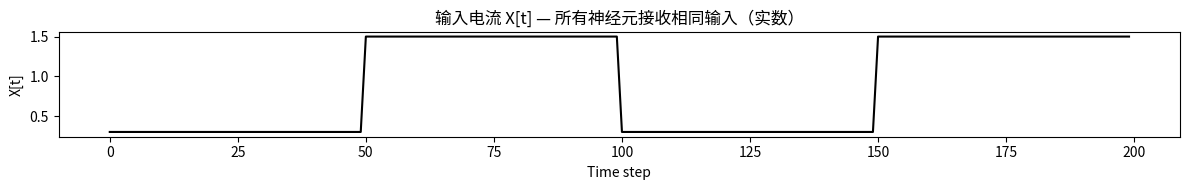

输入类型: torch.float32, 值域: [0.3, 1.5]
输入形状: torch.Size([200, 1]) = [T=200, batch=1]


In [38]:
T = 200  # 时间步
# 构造输入：前50步弱电流，中间50步强电流，再50步弱电流，最后50步强电流
x_seq = torch.zeros(T, 1)
x_seq[0:50] = 0.3
x_seq[50:100] = 1.5
x_seq[100:150] = 0.3
x_seq[150:200] = 1.5

plt.figure(figsize=(12, 2))
plt.plot(x_seq.numpy(), 'k-')
plt.title('输入电流 X[t] — 所有神经元接收相同输入（实数）')
plt.ylabel('X[t]')
plt.xlabel('Time step')
plt.tight_layout()
plt.show()

print(f'输入类型: {x_seq.dtype}, 值域: [{x_seq.min():.1f}, {x_seq.max():.1f}]')
print(f'输入形状: {x_seq.shape} = [T={T}, batch=1]')

In [39]:
# 定义所有神经元（排除LIAF，该版本有兼容性问题）
neurons = {
    'IF': neuron.IFNode(
        v_threshold=1.0, v_reset=0.0, 
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'LIF': neuron.LIFNode(
        tau=2.0, v_threshold=1.0, v_reset=0.0,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'PLIF': neuron.ParametricLIFNode(
        init_tau=2.0, v_threshold=1.0, v_reset=0.0,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'QIF': neuron.QIFNode(
        tau=2.0, v_c=0.8, a0=1.0,
        v_threshold=1.0, v_rest=0.0, v_reset=-0.1,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'EIF': neuron.EIFNode(
        tau=2.0, delta_T=1.0, theta_rh=0.8,
        v_threshold=1.0, v_rest=0.0, v_reset=0.0,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'Izhikevich': neuron.IzhikevichNode(
        tau=2.0, v_c=0.8, a0=1.0,
        v_threshold=1.0, v_reset=0.0, v_rest=-0.1,
        w_rest=0.0, tau_w=10.0, a=0.02, b=0.2,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
    'KLIF': neuron.KLIFNode(
        scale_reset=False, tau=2.0,
        v_threshold=1.0, v_reset=0.0,
        surrogate_function=surrogate.Sigmoid(),
        step_mode='s', store_v_seq=False
    ),
}

print(f'共 {len(neurons)} 种神经元模型 (LIAF因兼容性问题排除)')
for name in neurons:
    print(f'  - {name}')

共 7 种神经元模型 (LIAF因兼容性问题排除)
  - IF
  - LIF
  - PLIF
  - QIF
  - EIF
  - Izhikevich
  - KLIF


In [40]:
# 运行所有神经元，记录V和spike
results = {}

for name, n in neurons.items():
    n.reset()  # 重置状态
    v_list = []
    s_list = []
    w_list = []  # 仅Izhikevich
    
    for t in range(T):
        out = n(x_seq[t])  # 前向传播
        v_list.append(n.v.item())
        s_list.append(out.item())
        if hasattr(n, 'w') and name == 'Izhikevich':
            w_list.append(n.w.item())
    
    results[name] = {
        'v': np.array(v_list),
        's': np.array(s_list),
        'w': np.array(w_list) if w_list else None
    }
    
    # 分析输出类型
    unique_s = np.unique(np.round(results[name]['s'], 6))
    n_spikes = (np.array(s_list) > 0.5).sum()
    print(f'{name:12s} | V范围: [{min(v_list):.3f}, {max(v_list):.3f}] | '
          f'输出唯一值: {unique_s} | spike数: {n_spikes} | '
          f'输出是二进制: {len(unique_s) <= 2 and set(unique_s).issubset({0.0, 1.0})}')

IF           | V范围: [0.000, 0.900] | 输出唯一值: [0. 1.] | spike数: 124 | 输出是二进制: True
LIF          | V范围: [0.000, 0.900] | 输出唯一值: [0. 1.] | spike数: 50 | 输出是二进制: True
PLIF         | V范围: [0.000, 0.900] | 输出唯一值: [0. 1.] | spike数: 50 | 输出是二进制: True
QIF          | V范围: [-0.100, 0.974] | 输出唯一值: [0. 1.] | spike数: 59 | 输出是二进制: True
EIF          | V范围: [0.000, 0.975] | 输出唯一值: [0. 1.] | spike数: 75 | 输出是二进制: True
Izhikevich   | V范围: [-0.271, 0.998] | 输出唯一值: [0. 1.] | spike数: 37 | 输出是二进制: True
KLIF         | V范围: [0.000, 0.900] | 输出唯一值: [0. 1.] | spike数: 50 | 输出是二进制: True


## 2. 膜电位轨迹对比

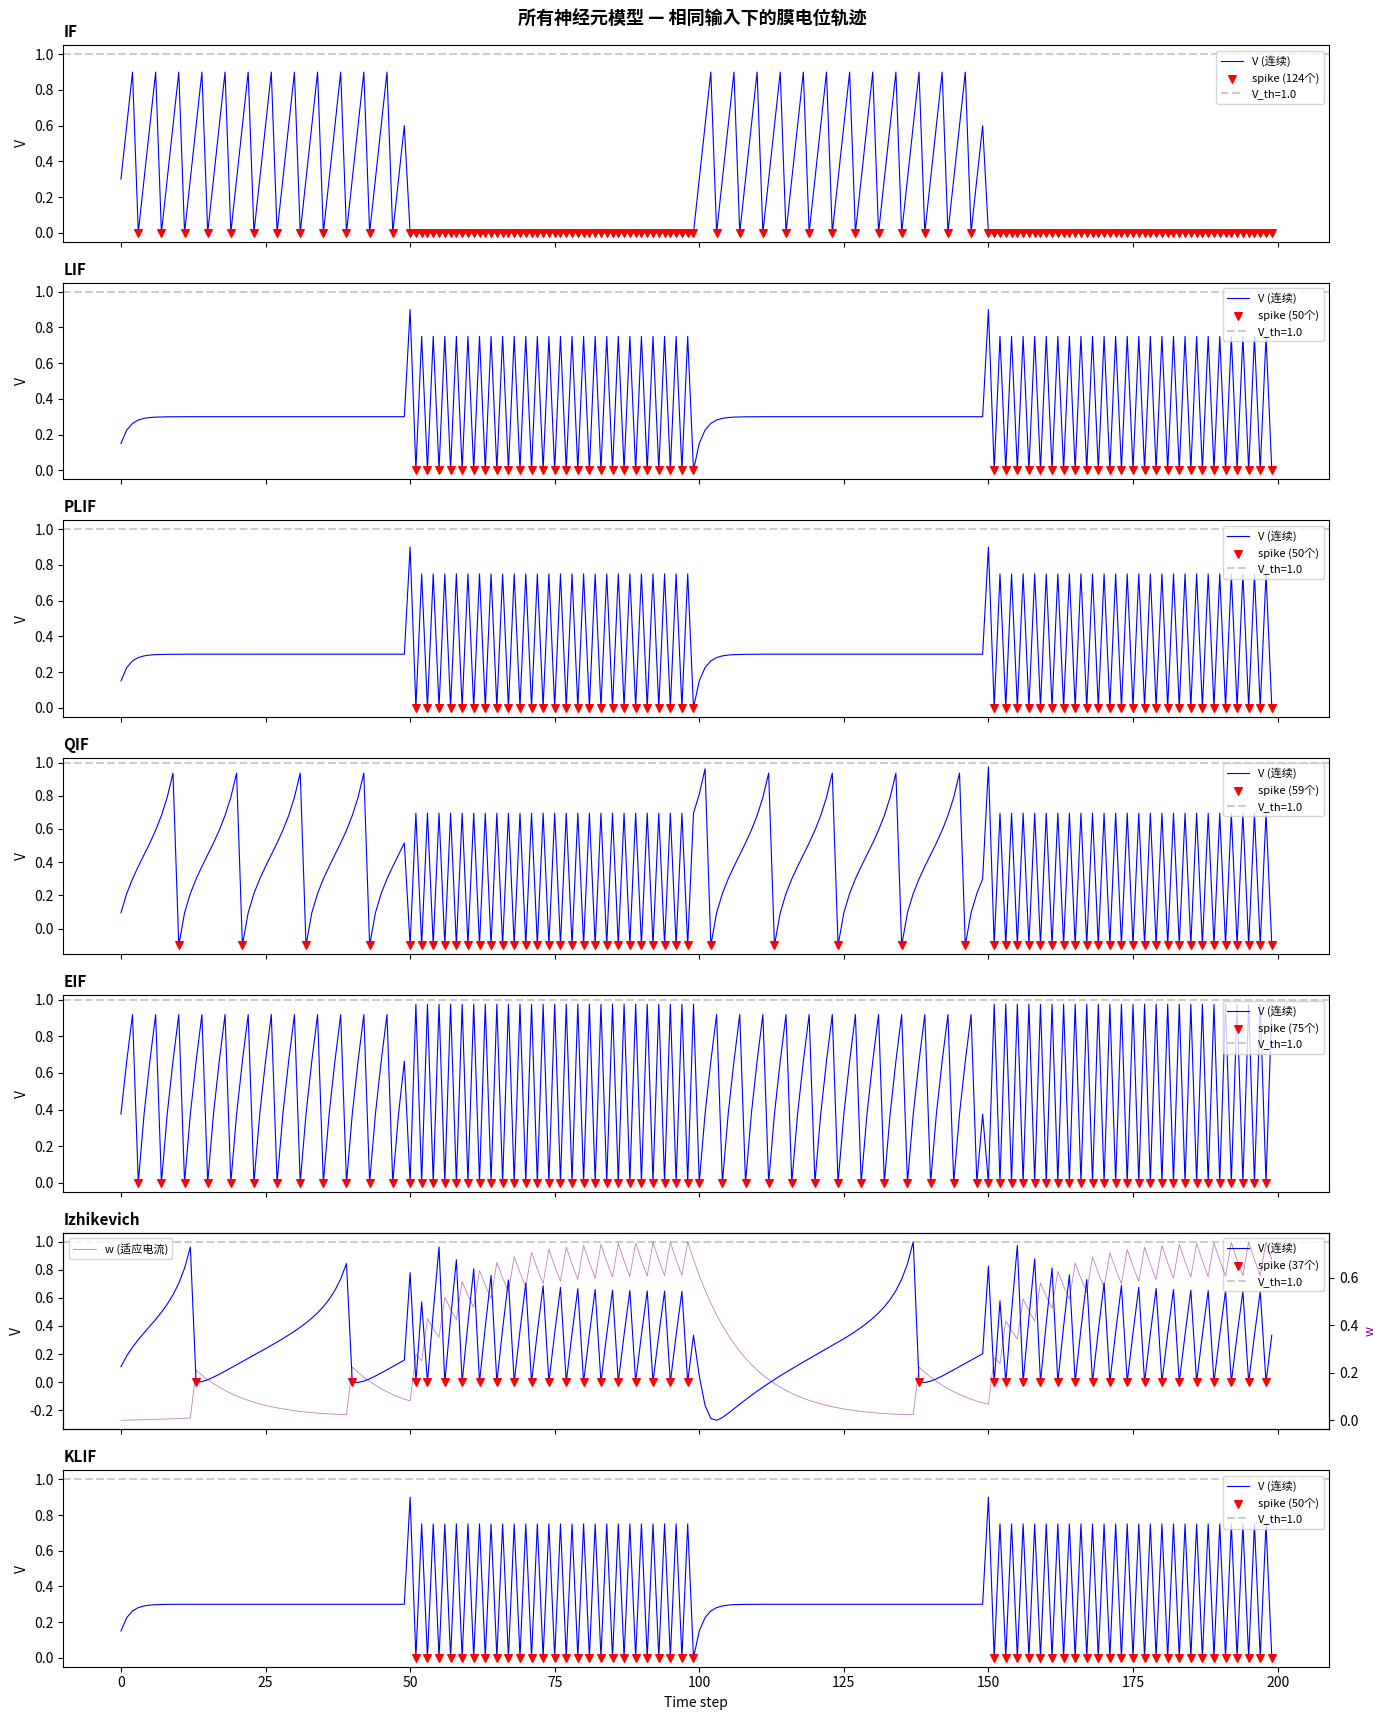

In [41]:
fig, axes = plt.subplots(len(results), 1, figsize=(14, 2.5 * len(results)), sharex=True)

for idx, (name, r) in enumerate(results.items()):
    ax = axes[idx]
    t = np.arange(T)
    
    # 膜电位
    ax.plot(t, r['v'], 'b-', linewidth=0.8, label='V (连续)')
    
    # spike标记
    spike_idx = np.where(r['s'] > 0.5)[0]
    if len(spike_idx) > 0:
        ax.scatter(spike_idx, r['v'][spike_idx], color='red', marker='v', s=30, zorder=5, label=f'spike ({len(spike_idx)}个)')
    
    # 阈值线
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.4, label='V_th=1.0')
    
    # 如果是LIAF，额外画输出
    if name == 'LIAF':
        ax.plot(t, r['s'], 'g-', linewidth=0.8, alpha=0.7, label='输出 act(V) (连续!)')
    
    # 如果是Izhikevich，画w
    if r['w'] is not None:
        ax2 = ax.twinx()
        ax2.plot(t, r['w'], 'purple', linewidth=0.6, alpha=0.5, label='w (适应电流)')
        ax2.set_ylabel('w', color='purple', fontsize=9)
        ax2.legend(loc='upper left', fontsize=8)
    
    ax.set_ylabel('V')
    ax.set_title(f'{name}', fontsize=11, fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=8)

axes[-1].set_xlabel('Time step')
fig.suptitle('所有神经元模型 — 相同输入下的膜电位轨迹', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Spike模式对比 (spikingjelly可视化)

<Figure size 1400x400 with 0 Axes>

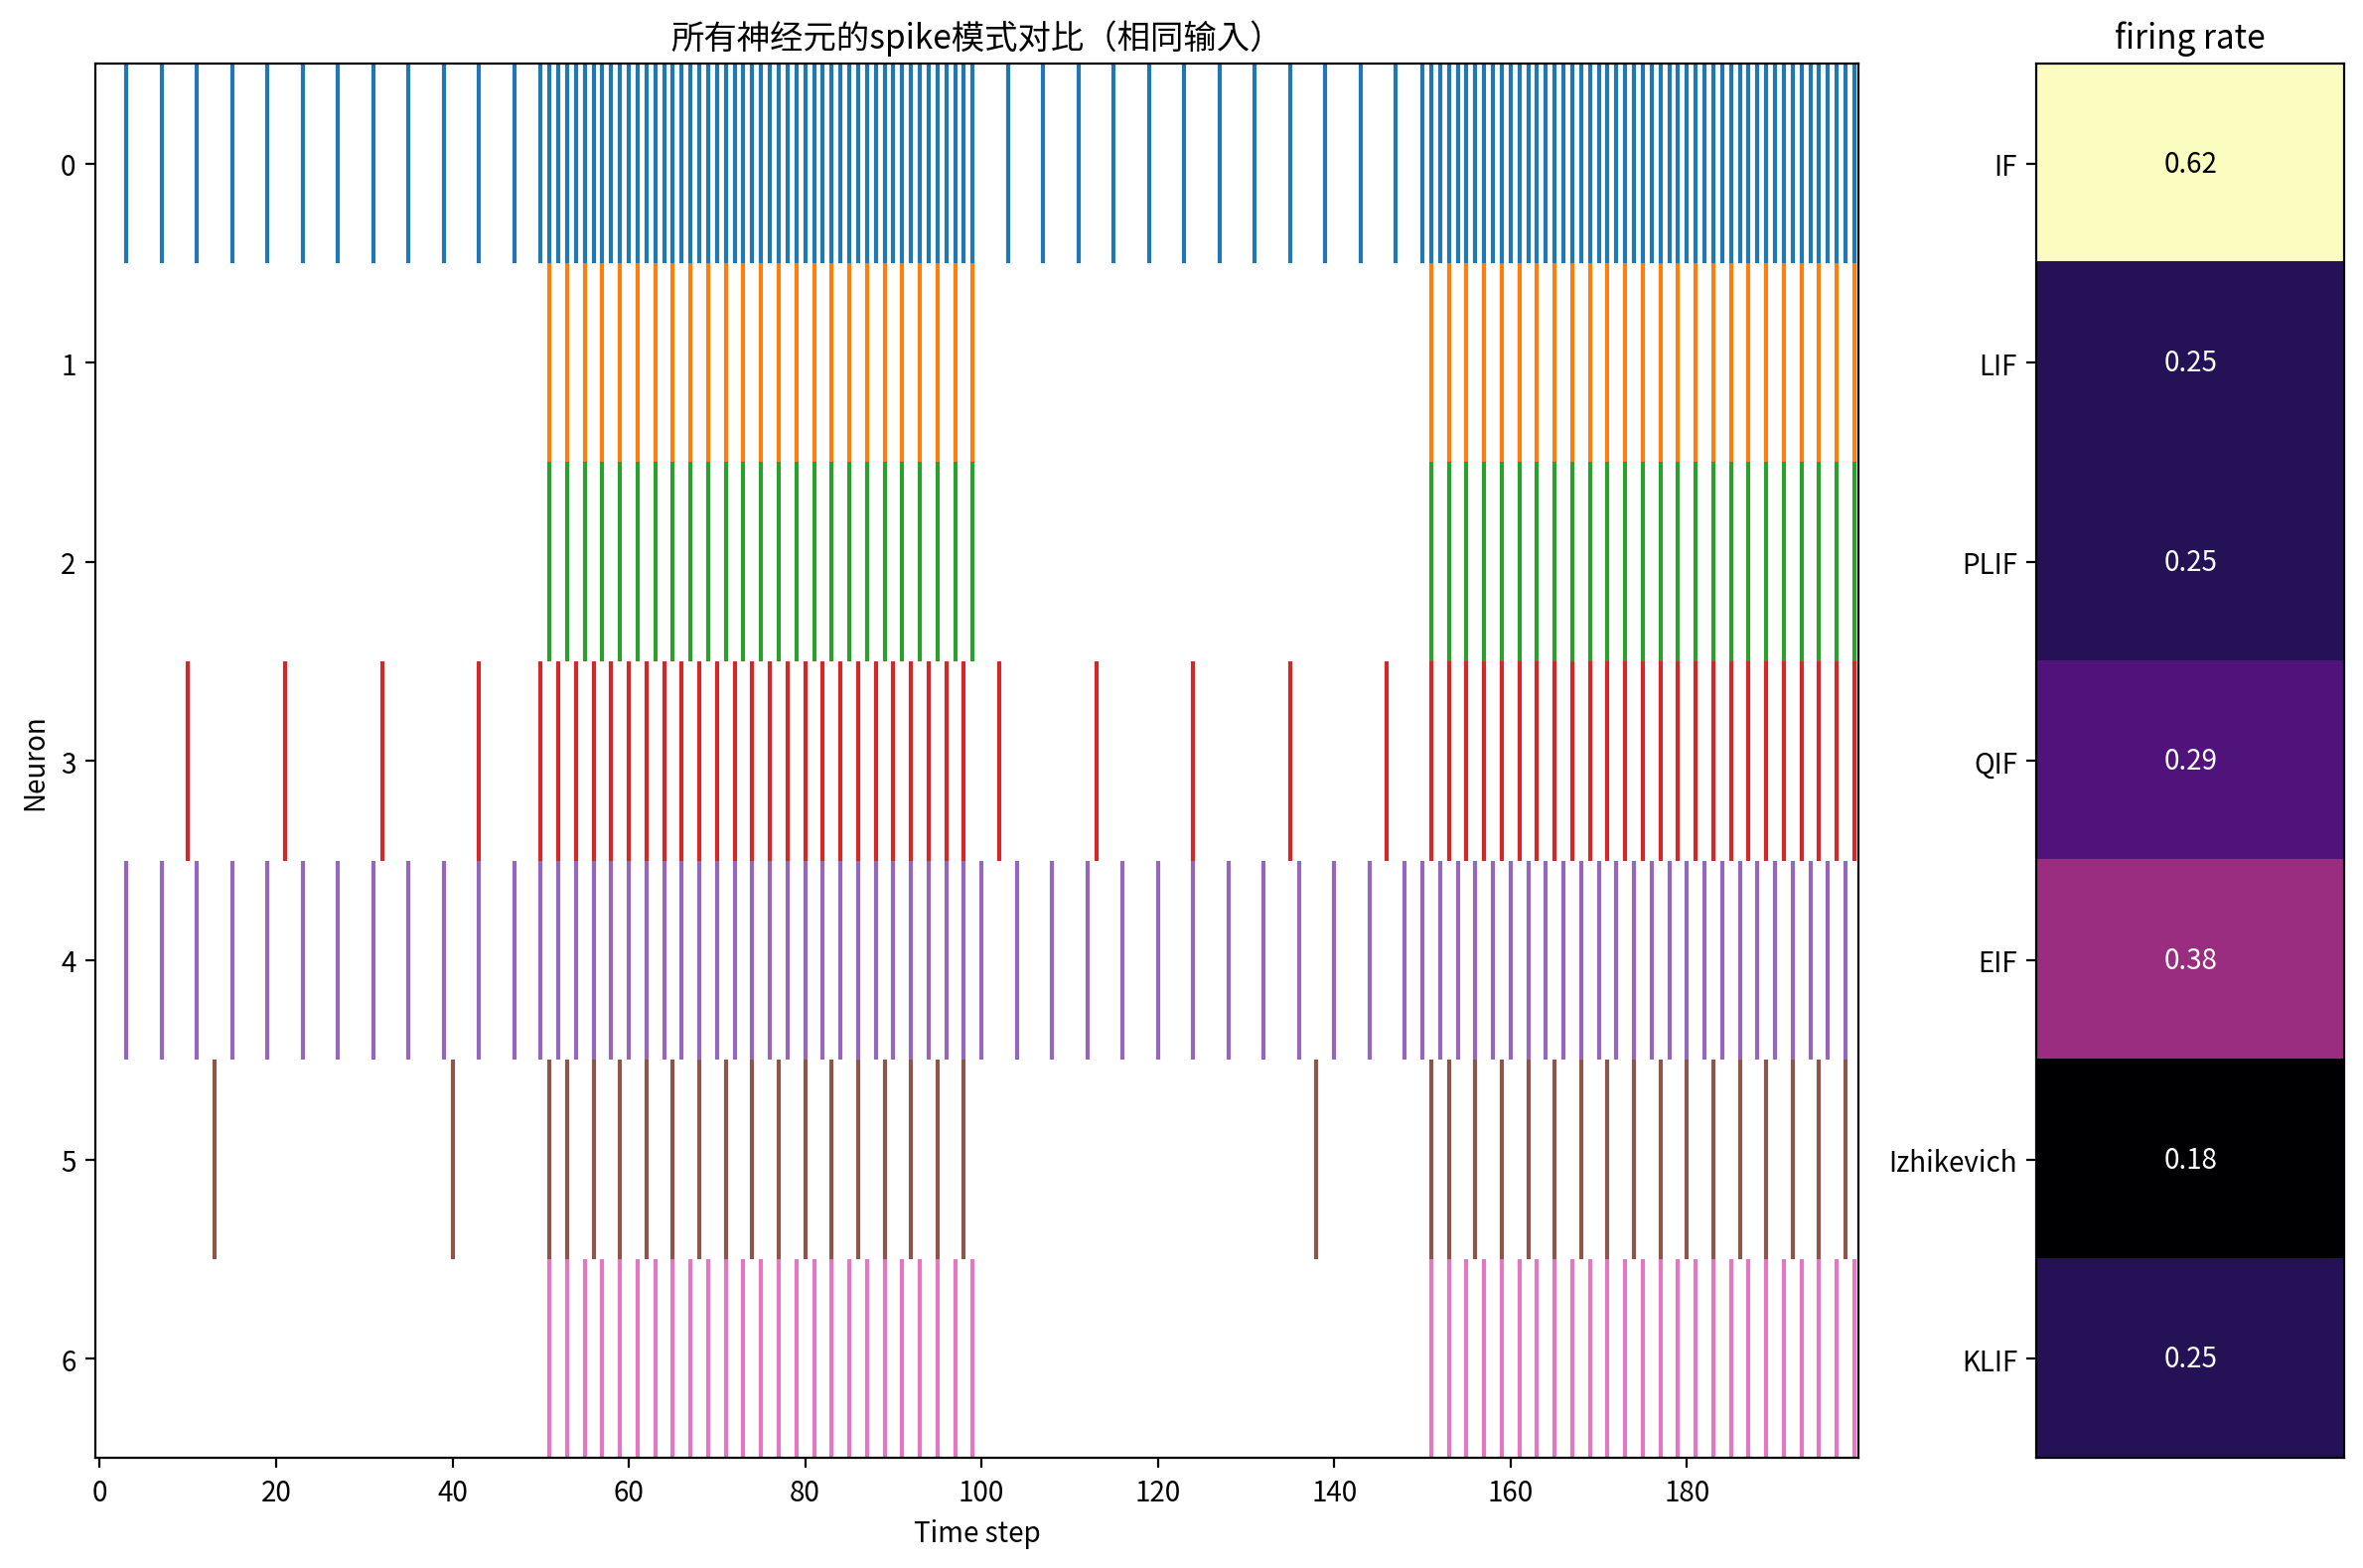

竖线=spike(1), 空白=无spike(0)
  IF: 124 spikes (发放率 62.0%)
  LIF: 50 spikes (发放率 25.0%)
  PLIF: 50 spikes (发放率 25.0%)
  QIF: 59 spikes (发放率 29.5%)
  EIF: 75 spikes (发放率 37.5%)
  Izhikevich: 37 spikes (发放率 18.5%)
  KLIF: 50 spikes (发放率 25.0%)


In [42]:
# 构造spike矩阵 [T, N_neurons]，排除LIAF（非二进制输出）
spike_names = [n for n in results if n != 'LIAF']
spike_matrix = np.zeros((T, len(spike_names)))
for j, name in enumerate(spike_names):
    spike_matrix[:, j] = (results[name]['s'] > 0.5).astype(float)

fig = plt.figure(figsize=(14, 4))
visualizing.plot_1d_spikes(
    spikes=spike_matrix,
    title='所有神经元的spike模式对比（相同输入）',
    xlabel='Time step',
    ylabel='Neuron'
)
plt.yticks(range(len(spike_names)), spike_names)
plt.tight_layout()
plt.show()

print('竖线=spike(1), 空白=无spike(0)')
for j, name in enumerate(spike_names):
    count = int(spike_matrix[:, j].sum())
    print(f'  {name}: {count} spikes (发放率 {count/T*100:.1f}%)')

## 4. 输入/输出类型汇总

In [43]:
print('=' * 90)
print(f'{"神经元":12s} | {"输入X[t]":12s} | {"状态变量":15s} | {"输出":15s} | {"输出值域":20s}')
print('=' * 90)

info = {
    'IF':         ('实数', 'V (1个)',       'spike (0/1)'),
    'LIF':        ('实数', 'V (1个)',       'spike (0/1)'),
    'PLIF':       ('实数', 'V (1个)',       'spike (0/1)'),
    'QIF':        ('实数', 'V (1个)',       'spike (0/1)'),
    'EIF':        ('实数', 'V (1个)',       'spike (0/1)'),
    'Izhikevich': ('实数', 'V, w (2个)',    'spike (0/1)'),
    'KLIF':       ('实数', 'V (1个)',       'spike (0/1)'),
}

for name, (inp, state, out) in info.items():
    r = results[name]
    unique_out = np.unique(np.round(r['s'], 4))
    if len(unique_out) > 5:
        out_range = f'[{r["s"].min():.3f}, {r["s"].max():.3f}] ({len(unique_out)}种)'
    else:
        out_range = f'{unique_out}'
    print(f'{name:12s} | {inp:12s} | {state:15s} | {out:15s} | {out_range}')

print('=' * 90)
print('\n注: LIAF因版本兼容性问题未包含。LIAF输出连续值act(V)，非spike。')
print('结论: 所有测试的神经元都是「实数进，二进制(0/1)出」')

神经元          | 输入X[t]       | 状态变量            | 输出              | 输出值域                
IF           | 实数           | V (1个)          | spike (0/1)     | [0. 1.]
LIF          | 实数           | V (1个)          | spike (0/1)     | [0. 1.]
PLIF         | 实数           | V (1个)          | spike (0/1)     | [0. 1.]
QIF          | 实数           | V (1个)          | spike (0/1)     | [0. 1.]
EIF          | 实数           | V (1个)          | spike (0/1)     | [0. 1.]
Izhikevich   | 实数           | V, w (2个)       | spike (0/1)     | [0. 1.]
KLIF         | 实数           | V (1个)          | spike (0/1)     | [0. 1.]

注: LIAF因版本兼容性问题未包含。LIAF输出连续值act(V)，非spike。
结论: 所有测试的神经元都是「实数进，二进制(0/1)出」


## 5. 阈下动力学方程对比

In [44]:
equations = {
    'IF': {
        'eq': 'H[t] = V[t-1] + X[t]',
        'states': 1,
        'nonlinearity': '无 (纯线性积分)',
        'v_dependent': '无',
        'reset': '人工hard/soft reset',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1 (无衰减)',
    },
    'LIF': {
        'eq': 'H[t] = V[t-1] + (1/τ)(X[t] - (V[t-1] - V_reset))',
        'states': 1,
        'nonlinearity': '无 (线性衰减)',
        'v_dependent': '线性衰减项 -(V-V_reset)/τ',
        'reset': '人工hard/soft reset',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1 (由τ决定)',
    },
    'PLIF': {
        'eq': '同LIF，但τ可学习: τ = 1/(1+exp(-w))',
        'states': 1,
        'nonlinearity': '无 (τ可学习但仍是线性衰减)',
        'v_dependent': '同LIF',
        'reset': '人工hard/soft reset',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1 (可学习的τ)',
    },
    'QIF': {
        'eq': 'H[t] = V[t-1] + (1/τ)(X[t] + a₀(V-V_rest)(V-V_c))',
        'states': 1,
        'nonlinearity': '二次项 a₀(V-V_rest)(V-V_c)',
        'v_dependent': '二次: V²系数 → V高时加速去极化',
        'reset': '人工hard/soft reset',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1 (但非线性使有效τ随V变化)',
    },
    'EIF': {
        'eq': 'H[t] = V[t-1] + (1/τ)(X[t] - (V-V_rest) + Δ_T·exp((V-θ_rh)/Δ_T))',
        'states': 1,
        'nonlinearity': '指数项 Δ_T·exp((V-θ_rh)/Δ_T) 模拟Na⁺激活',
        'v_dependent': '指数: V接近θ_rh时急剧增强 → 模拟HH的m³',
        'reset': '人工hard/soft reset',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1 (但指数非线性使阈值附近行为尖锐)',
    },
    'Izhikevich': {
        'eq': 'V: 同QIF但减去w; w: w + (1/τ_w)(a(V-V_rest)-w), spike时w+=b',
        'states': 2,
        'nonlinearity': '二次项 + 适应电流w的耦合',
        'v_dependent': '二次(V部分) + w通过a(V-V_rest)跟踪V',
        'reset': '人工hard/soft reset + w跳变(w+=b)',
        'refractory': '部分: w升高后抑制发放 (类不应期)',
        'adaptation': '有: w提供负反馈，发放越多w越大',
        'timescales': '2 (V快, w慢，由τ_w控制)',
    },
    'LIAF': {
        'eq': '同LIF，但输出=act(V)而非spike',
        'states': 1,
        'nonlinearity': '输出非线性 act()',
        'v_dependent': '同LIF',
        'reset': '人工hard/soft reset (内部仍有spike)',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1',
    },
    'KLIF': {
        'eq': '同LIF，发放: F=ReLU(kH), S=Θ(F-V_th)',
        'states': 1,
        'nonlinearity': 'ReLU(kH) 可学习斜率k',
        'v_dependent': '同LIF + ReLU门控',
        'reset': '人工hard/soft reset (可选缩放)',
        'refractory': '无',
        'adaptation': '无',
        'timescales': '1',
    },
}

# 打印对比表
for name, eq in equations.items():
    print(f'\n{"="*60}')
    print(f'  {name}')
    print(f'{"="*60}')
    print(f'  方程:       {eq["eq"]}')
    print(f'  状态变量数: {eq["states"]}')
    print(f'  非线性:     {eq["nonlinearity"]}')
    print(f'  V依赖性:    {eq["v_dependent"]}')
    print(f'  重置机制:   {eq["reset"]}')
    print(f'  不应期:     {eq["refractory"]}')
    print(f'  适应性:     {eq["adaptation"]}')
    print(f'  时间尺度:   {eq["timescales"]}')


  IF
  方程:       H[t] = V[t-1] + X[t]
  状态变量数: 1
  非线性:     无 (纯线性积分)
  V依赖性:    无
  重置机制:   人工hard/soft reset
  不应期:     无
  适应性:     无
  时间尺度:   1 (无衰减)

  LIF
  方程:       H[t] = V[t-1] + (1/τ)(X[t] - (V[t-1] - V_reset))
  状态变量数: 1
  非线性:     无 (线性衰减)
  V依赖性:    线性衰减项 -(V-V_reset)/τ
  重置机制:   人工hard/soft reset
  不应期:     无
  适应性:     无
  时间尺度:   1 (由τ决定)

  PLIF
  方程:       同LIF，但τ可学习: τ = 1/(1+exp(-w))
  状态变量数: 1
  非线性:     无 (τ可学习但仍是线性衰减)
  V依赖性:    同LIF
  重置机制:   人工hard/soft reset
  不应期:     无
  适应性:     无
  时间尺度:   1 (可学习的τ)

  QIF
  方程:       H[t] = V[t-1] + (1/τ)(X[t] + a₀(V-V_rest)(V-V_c))
  状态变量数: 1
  非线性:     二次项 a₀(V-V_rest)(V-V_c)
  V依赖性:    二次: V²系数 → V高时加速去极化
  重置机制:   人工hard/soft reset
  不应期:     无
  适应性:     无
  时间尺度:   1 (但非线性使有效τ随V变化)

  EIF
  方程:       H[t] = V[t-1] + (1/τ)(X[t] - (V-V_rest) + Δ_T·exp((V-θ_rh)/Δ_T))
  状态变量数: 1
  非线性:     指数项 Δ_T·exp((V-θ_rh)/Δ_T) 模拟Na⁺激活
  V依赖性:    指数: V接近θ_rh时急剧增强 → 模拟HH的m³
  重置机制:   人工hard/soft reset
  不应期:     无
  适应性:     无
  时

## 6. 对隐神经元状态空间设计的适用性评估

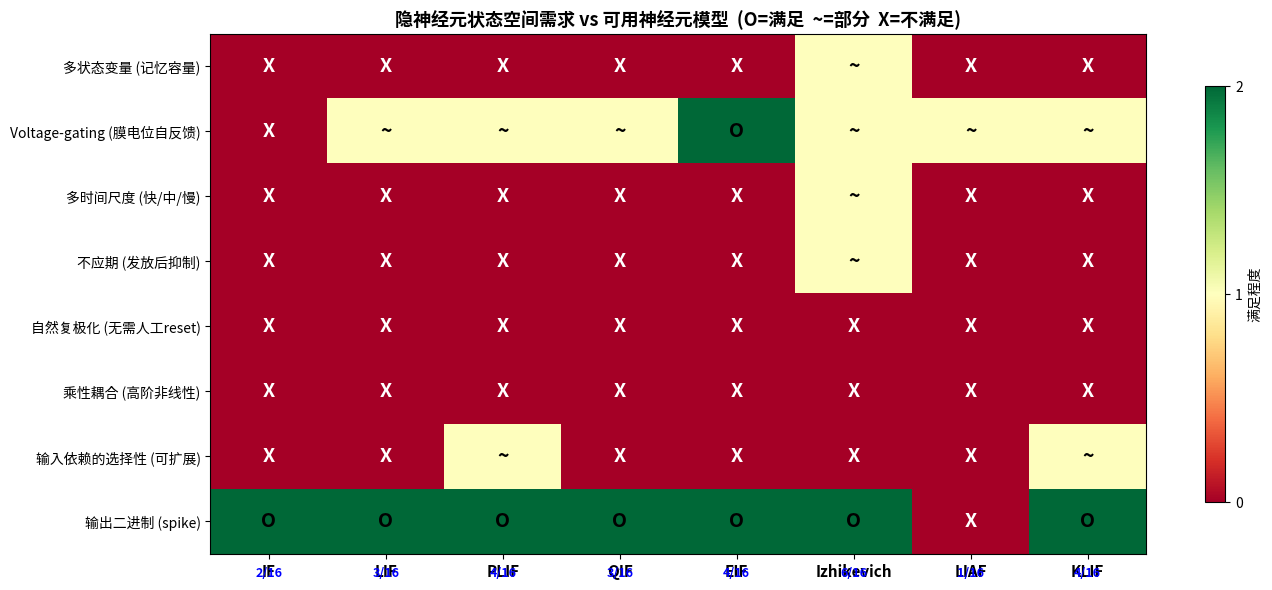


总分排名:
  Izhikevich  : 6/16
  PLIF        : 4/16
  EIF         : 4/16
  KLIF        : 4/16
  LIF         : 3/16
  QIF         : 3/16
  IF          : 2/16
  LIAF        : 1/16


In [45]:
requirements = [
    '多状态变量 (记忆容量)',
    'Voltage-gating (膜电位自反馈)',
    '多时间尺度 (快/中/慢)',
    '不应期 (发放后抑制)',
    '自然复极化 (无需人工reset)',
    '乘性耦合 (高阶非线性)',
    '输入依赖的选择性 (可扩展)',
    '输出二进制 (spike)',
]

# 评分: 0=无, 1=部分, 2=完全
scores = {
    'IF':         [0, 0, 0, 0, 0, 0, 0, 2],
    'LIF':        [0, 1, 0, 0, 0, 0, 0, 2],
    'PLIF':       [0, 1, 0, 0, 0, 0, 1, 2],
    'QIF':        [0, 1, 0, 0, 0, 0, 0, 2],
    'EIF':        [0, 2, 0, 0, 0, 0, 0, 2],
    'Izhikevich': [1, 1, 1, 1, 0, 0, 0, 2],
    'LIAF':       [0, 1, 0, 0, 0, 0, 0, 0],
    'KLIF':       [0, 1, 0, 0, 0, 0, 1, 2],
}

# 绘制热力图
model_names = list(scores.keys())
score_matrix = np.array([scores[n] for n in model_names])

fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(score_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=2)

ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, fontsize=11, fontweight='bold')
ax.set_yticks(range(len(requirements)))
ax.set_yticklabels(requirements, fontsize=10)

# 标注分数 — 使用ASCII字符避免字体缺失
labels = {0: 'X', 1: '~', 2: 'O'}
for i in range(len(model_names)):
    for j in range(len(requirements)):
        val = score_matrix[i, j]
        ax.text(i, j, labels[val], ha='center', va='center', fontsize=14,
                fontweight='bold', color='white' if val == 0 else 'black')

# 总分
totals = score_matrix.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, len(requirements) - 0.3, f'{total}/{2*len(requirements)}', 
            ha='center', va='top', fontsize=9, color='blue', fontweight='bold')

ax.set_title('隐神经元状态空间需求 vs 可用神经元模型  (O=满足  ~=部分  X=不满足)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, ticks=[0, 1, 2], label='满足程度', shrink=0.8)
plt.tight_layout()
plt.show()

print('\n总分排名:')
for name, total in sorted(zip(model_names, totals), key=lambda x: -x[1]):
    print(f'  {name:12s}: {total}/{2*len(requirements)}')

## 7. 各模型与HH的距离分析

In [46]:
print('''
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                     各神经元模型 → HH 的距离                                         │
├──────────────┬──────────────────────────────────────────────────────────────────────┤
│ 模型         │ 缺少的HH特性                                                        │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ IF           │ 缺: 衰减、V依赖非线性、多变量、不应期、复极化 — 全缺                    │
│              │ 距离HH: ★★★★★ (最远)                                                 │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ LIF          │ 缺: V依赖非线性、多变量、不应期、复极化                                 │
│              │ 有: 线性衰减 (对应HH的leak)                                           │
│              │ 距离HH: ★★★★                                                         │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ PLIF         │ 同LIF，但τ可学习 → 可以调节衰减速率                                    │
│              │ 仍缺: V依赖非线性、多变量、不应期、复极化                               │
│              │ 距离HH: ★★★★                                                         │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ QIF          │ 有: V²非线性 → 粗略模拟Na⁺激活的正反馈                                 │
│              │ 缺: 多变量、不应期、复极化、失活(h)                                    │
│              │ 距离HH: ★★★                                                          │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ EIF          │ 有: exp项 → 精确模拟HH的Na⁺激活(m³)在阈值附近的行为                    │
│              │ 缺: 多变量、不应期、复极化、失活(h)、K⁺动力学(n)                       │
│              │ 说明: 数学上是HH在spike起始阶段的一维约化                               │
│              │ 距离HH: ★★★ (spike起始最准，但发放后行为完全不同)                       │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ Izhikevich   │ 有: 2个状态变量(V,w)、适应(类不应期)、二次非线性                       │
│              │ 缺: 3个独立门控(只有1个w)、乘性耦合(w是加性)、                         │
│              │      自然复极化(仍需人工reset)、离子通道特异性(Na/K不分)                │
│              │ 说明: 2D简化，能复现多种发放模式但机制不同                               │
│              │ 距离HH: ★★ (最近，但仍有根本差异)                                      │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ LIAF         │ 同LIF，但输出不是spike → 不适合我们的设计                              │
│              │ 距离HH: 不适用                                                        │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ KLIF         │ 同LIF + 可学习k → 轻微改进                                            │
│              │ 距离HH: ★★★★                                                         │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│              │                                                                      │
│ 完整HH       │ 4状态(V,m,h,n)、3种离子通道、乘性耦合m³h和n⁴、                        │
│ (需自实现)    │ 自然复极化、不应期、多时间尺度 — 全部具备                              │
│              │ 距离HH: ★ (就是HH本身)                                                │
└──────────────┴──────────────────────────────────────────────────────────────────────┘
''')


┌─────────────────────────────────────────────────────────────────────────────────────┐
│                     各神经元模型 → HH 的距离                                         │
├──────────────┬──────────────────────────────────────────────────────────────────────┤
│ 模型         │ 缺少的HH特性                                                        │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ IF           │ 缺: 衰减、V依赖非线性、多变量、不应期、复极化 — 全缺                    │
│              │ 距离HH: ★★★★★ (最远)                                                 │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ LIF          │ 缺: V依赖非线性、多变量、不应期、复极化                                 │
│              │ 有: 线性衰减 (对应HH的leak)                                           │
│              │ 距离HH: ★★★★                                                         │
├──────────────┼──────────────────────────────────────────────────────────────────────┤
│ PLIF 

## 8. 关键差异实验：发放后行为对比

HH的核心特性之一是发放后的自然复极化和不应期。看看现有模型怎么处理。

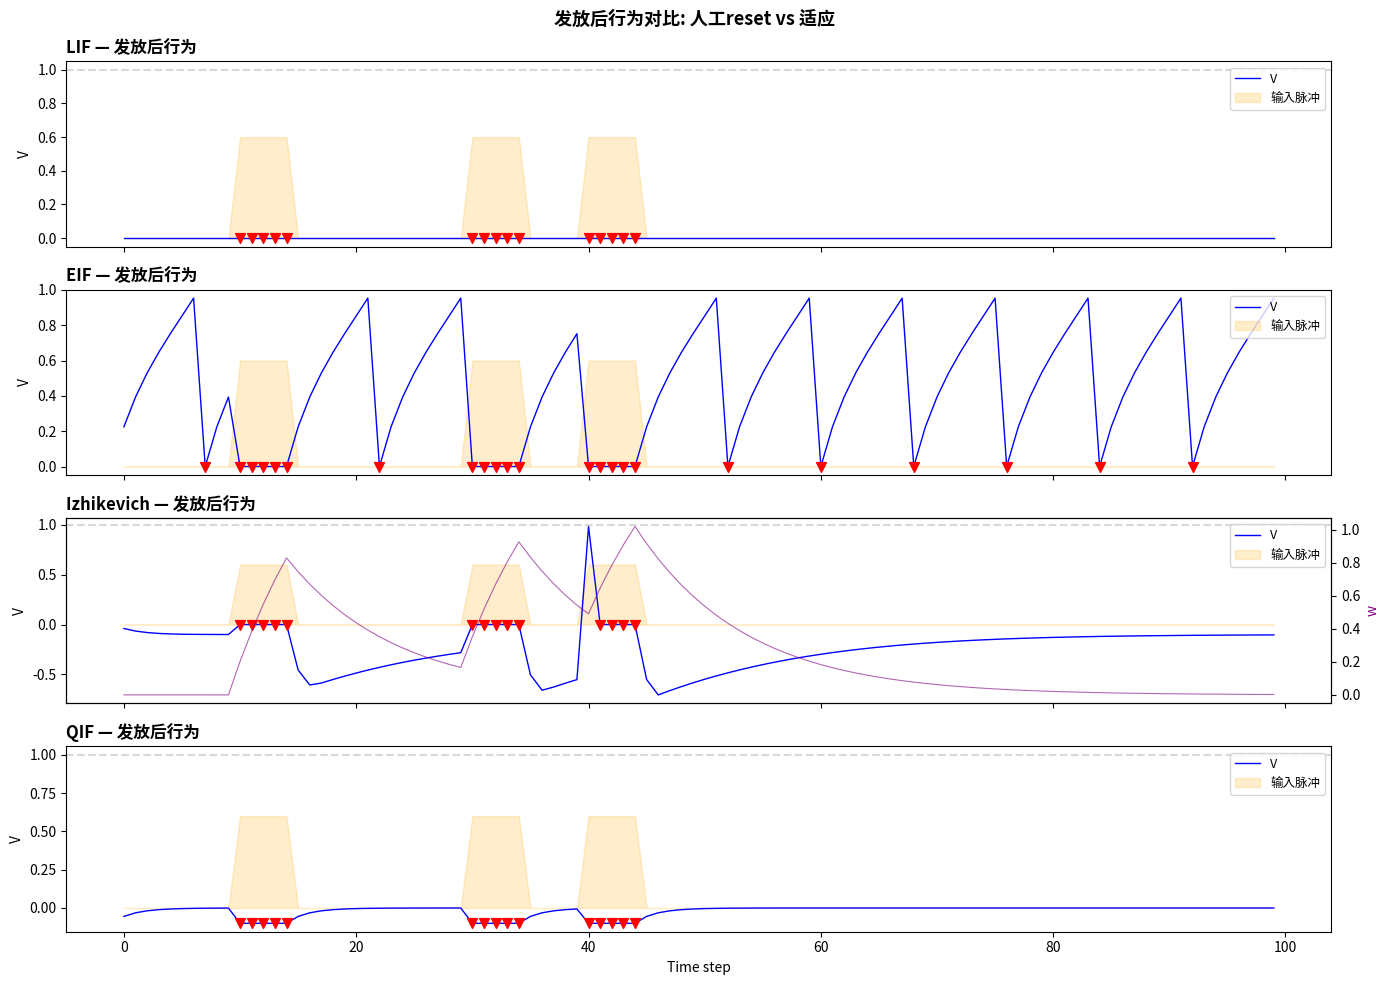

观察:
  LIF/EIF/QIF: 发放后V被人工重置到V_reset，没有不应期
  Izhikevich: 发放后w跳变(w+=b)，w升高抑制后续发放 → 类似不应期
  所有模型: 都依赖人工reset，没有自然复极化


In [47]:
# 给一个短促强输入，然后观察发放后行为
T2 = 100
x_pulse = torch.zeros(T2, 1)
x_pulse[10:15] = 3.0  # 第10-15步：强脉冲
x_pulse[30:35] = 3.0  # 第30-35步：第二次强脉冲
x_pulse[40:45] = 3.0  # 第40-45步：紧接第三次（测试不应期）

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

test_models = ['LIF', 'EIF', 'Izhikevich', 'QIF']

for idx, name in enumerate(test_models):
    n = neurons[name]
    n.reset()
    v_list, s_list, w_list = [], [], []
    
    for t in range(T2):
        out = n(x_pulse[t])
        v_list.append(n.v.item())
        s_list.append(out.item())
        if hasattr(n, 'w') and name == 'Izhikevich':
            w_list.append(n.w.item())
    
    ax = axes[idx]
    t_arr = np.arange(T2)
    ax.plot(t_arr, v_list, 'b-', linewidth=1, label='V')
    ax.fill_between(t_arr, 0, x_pulse.squeeze().numpy() * 0.2, alpha=0.2, color='orange', label='输入脉冲')
    
    spike_idx = np.where(np.array(s_list) > 0.5)[0]
    if len(spike_idx) > 0:
        ax.scatter(spike_idx, [v_list[i] for i in spike_idx], color='red', marker='v', s=50, zorder=5)
    
    if w_list:
        ax2 = ax.twinx()
        ax2.plot(t_arr, w_list, 'purple', linewidth=0.8, alpha=0.6, label='w')
        ax2.set_ylabel('w', color='purple')
    
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    ax.set_ylabel('V')
    ax.set_title(f'{name} — 发放后行为', fontweight='bold', loc='left')
    ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Time step')
fig.suptitle('发放后行为对比: 人工reset vs 适应', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('观察:')
print('  LIF/EIF/QIF: 发放后V被人工重置到V_reset，没有不应期')
print('  Izhikevich: 发放后w跳变(w+=b)，w升高抑制后续发放 → 类似不应期')
print('  所有模型: 都依赖人工reset，没有自然复极化')